# Úkol s ArUco
Kódy [ArUco (Augmented Reality University of Cordoba)](https://doi.org/10.1016/j.patcog.2014.01.005) se používají mimojiné i k **odhadu polohy kamery**.

Kódy se dělí na několik typů podle velikosti a počtu různých identifikátorů.
Jejich čtvercový tvar umožňuje odhadnout polohu kamery z **jednoho** kódu. Binární kódování umožňuje identifikaci konkrétního ID a detekci částečně zakrytého markeru.

**Cílem domácího úkolu je vložit 3D modely do videa tak, aby vykreslení modelu odpovídalo natočení a poloze ArUco kódu, na který se bude 3D model vykreslovat.** Za tuto část lze získat **3 body** a až **1 bod** prémiový.

![](data/image/output-example.png "Ukázka výstupu")

V úkolu si ukážeme, jak se značkami pracovat [pomocí knihovny `cv2`](https://docs.opencv.org/4.x/d2/d64/tutorial_table_of_content_objdetect.html), tj. projdeme si následující témata:
- detekce markerů
- odhad polohy kamery (camera pose estimation)
- porozumění návratovým parametrům
- načtení a předzpracování 3D objektů
- projekce 3D objektu do obrazu, tj. jednoduchá ukázka rozšířené reality
- následné zpracování videa

In [274]:
# # Turn on an explicit auto-reload of packages.
# # This should eliminate the need for reloading jupyter after every change made to imported functions.
%load_ext autoreload
%autoreload 1
# #   only reload the ArUco module 
%aimport ArUco

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import knihoven

In [275]:
import os
from typing import Dict

import cv2
import numpy as np
import matplotlib.pyplot as plt
import trimesh

from improutils import plot_images, load_image, to_gray, camera_calib

from ArUco.detection import infer_aruco_type
from ArUco.process_video import process_video
from ArUco.visualise import draw_aruco
from ArUco.constants import Color

## Definice pomocných funkcí

In [276]:
def plot_mesh(mesh: trimesh.base.Trimesh, title=None):
    """
    Plot vertices of a 3D mesh along their X and Y axis.
    """
    plt.xlabel('X')
    plt.ylabel('Y')
    if title is None:
        title = 'Model vertices projected onto the XY plane'
    v = mesh.vertices.copy()
    x = v[..., 0]
    y = v[..., 1]
    plt.scatter(x=x, y=y, s=1)
    plt.axhline(0, c='black')
    plt.axvline(0, c='black')
    plt.title(title)
    plt.show()

## Detekce ArUco
Na správnou detekci ArUco a následnou projekci potřebujeme zkalibrovanou kameru.

Využijte funkci `camera_calib` knihovny improutils a video `data/video/calibration.mp4` k získání parametrů kamery.

Img 0 is being processed..
Img 1 is being processed..
Img 2 is being processed..
Img 3 is being processed..
Img 4 is being processed..
Img 5 is being processed..
Img 6 is being processed..
Img 7 is being processed..
Img 8 is being processed..
Img 9 is being processed..
Img 10 is being processed..
Img 11 is being processed..
Img 12 is being processed..
Img 13 is being processed..
Img 14 is being processed..
Img 15 is being processed..
Img 16 is being processed..
Img 17 is being processed..
Img 18 is being processed..
Img 19 is being processed..
Img 20 is being processed..
Img 21 is being processed..
Img 22 is being processed..
Img 23 is being processed..
Img 24 is being processed..
Img 25 is being processed..
Img 26 is being processed..
Img 27 is being processed..
Img 28 is being processed..
Img 29 is being processed..
Img 30 is being processed..
Img 31 is being processed..
Img 32 is being processed..
Img 33 is being processed..
Img 34 is being processed..
Img 35 is being processed..
Im

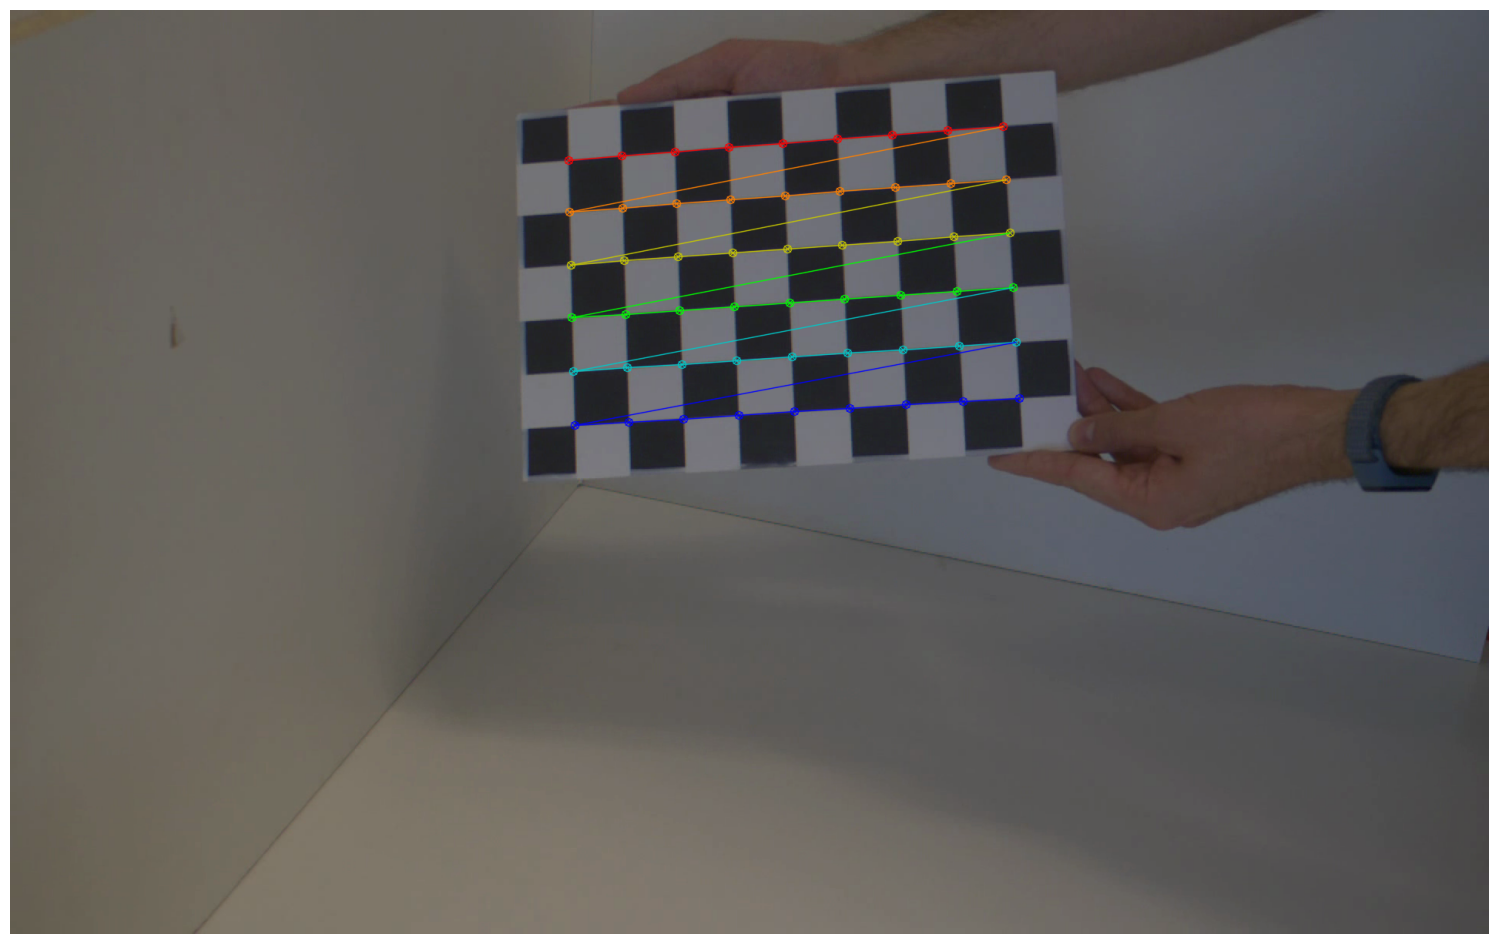

In [277]:
camera_matrix, dist_coefs, _ = camera_calib("data/video/calibration.mp4", (9, 6)) ###

Načtěte a zobrazte obrázek `data/image/aruco_img.png`, na kterém si nacvičíme práci s ArUco. Připravte si obraz v šedotónu.

WARNING titles length is not the same as images length!


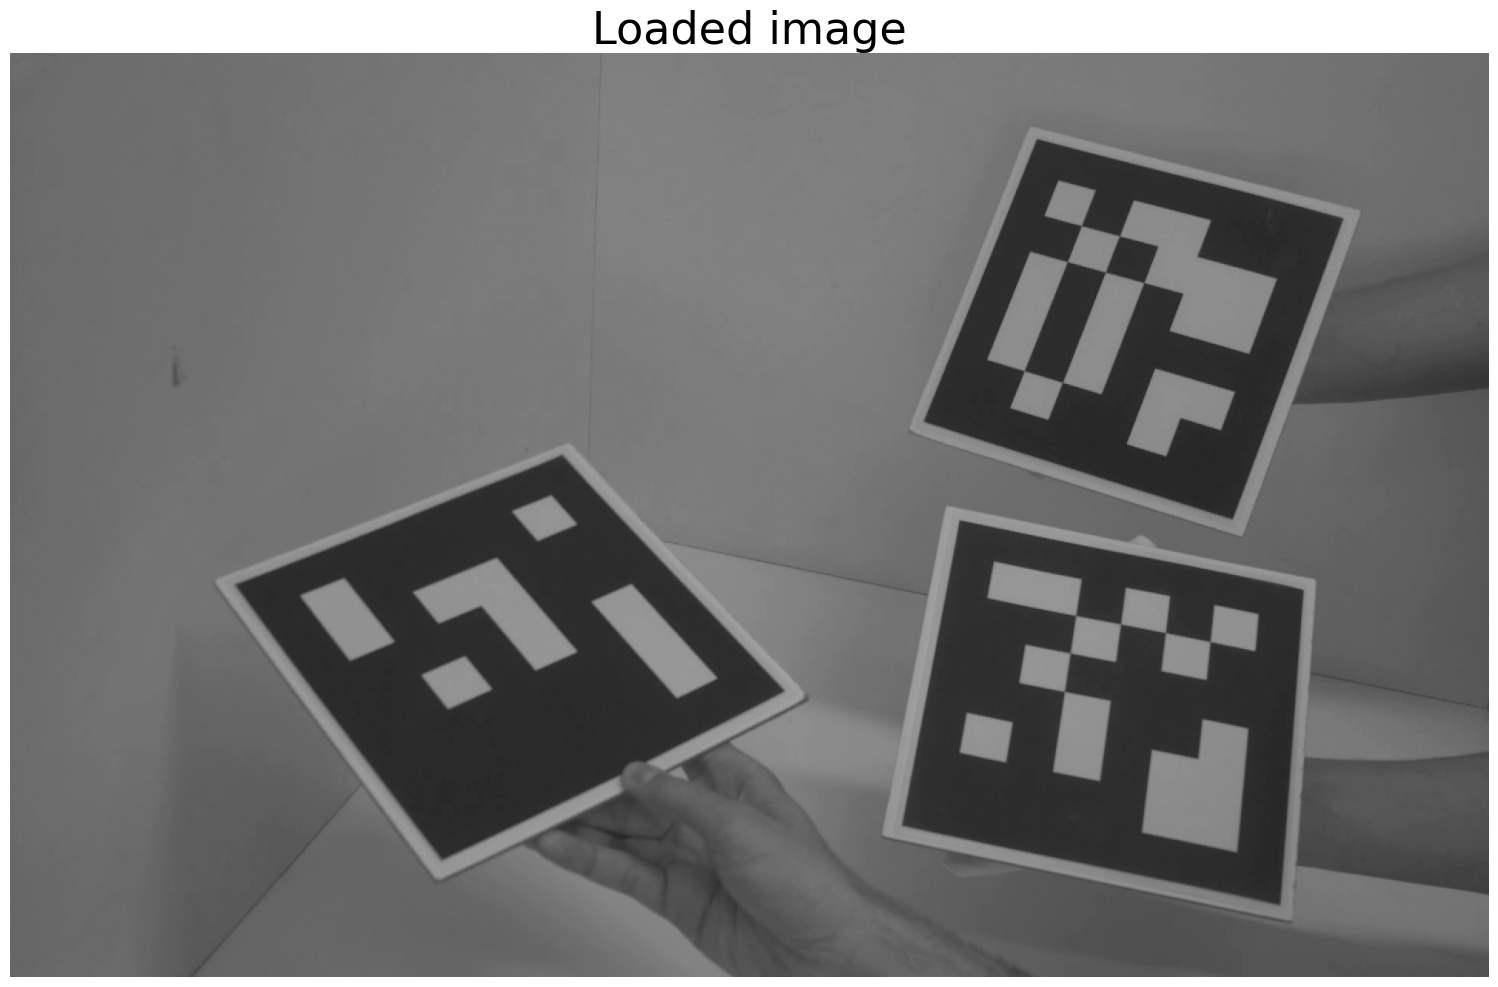

In [278]:
img = load_image("data/image/aruco_img.png") ###
img_gray = to_gray(img) ###
plot_images(img_gray, titles=['Loaded image', 'Grayscale image']) ###

### Zjištění typu ArUco značek

V praxi můžete dopředu znát typ značek, se kterými budete pracovat, ale těch typů je tolik, že se hodí mít "trik v rukávu", který vám ušetří čas. Tímto trikem je právě funkce `infer_aruco_type`. 

Funkce zkusí detekovat značky dle všech typů předdefinovaných v `ArUco/constants.py` a vrátí OpenCV detector spolu s výsledkem detekce pro typ nejčastěji se vyskytující značky v obrázku.

Funkce vrací `namedtuple`, který obsahuje následující položky:
- `marker_name` := string reprezentace typu
- `marker_type` := cv2 reprezentace typu
- `marker_count` := počet správně detekovaných značek 
- `detector` := cv2 třída na detekci ArUco značek
- `corners` := rohy správně detekovaných značek v obrazu
- `ids` := identifikátory značek z corners
- `rejected` := rohy špatně identifikovaných značek (často to vůbec nejsou značky, ale spíše části obrazu tvarem podobné ArUco)
- `detection` := (corners, ids, rejected)

Na detekci ArUco využijte funkci `infer_aruco_type`.

In [279]:
inference = infer_aruco_type(img_gray) ###
corners, ids, rejected = detection = inference.detection

Detected 3 markers of type 'DICT_ARUCO_MIP_36H12'.


Vizualizujte polohu a ID detekovaných značek na načteném obrázku za pomoci `draw_aruco`.

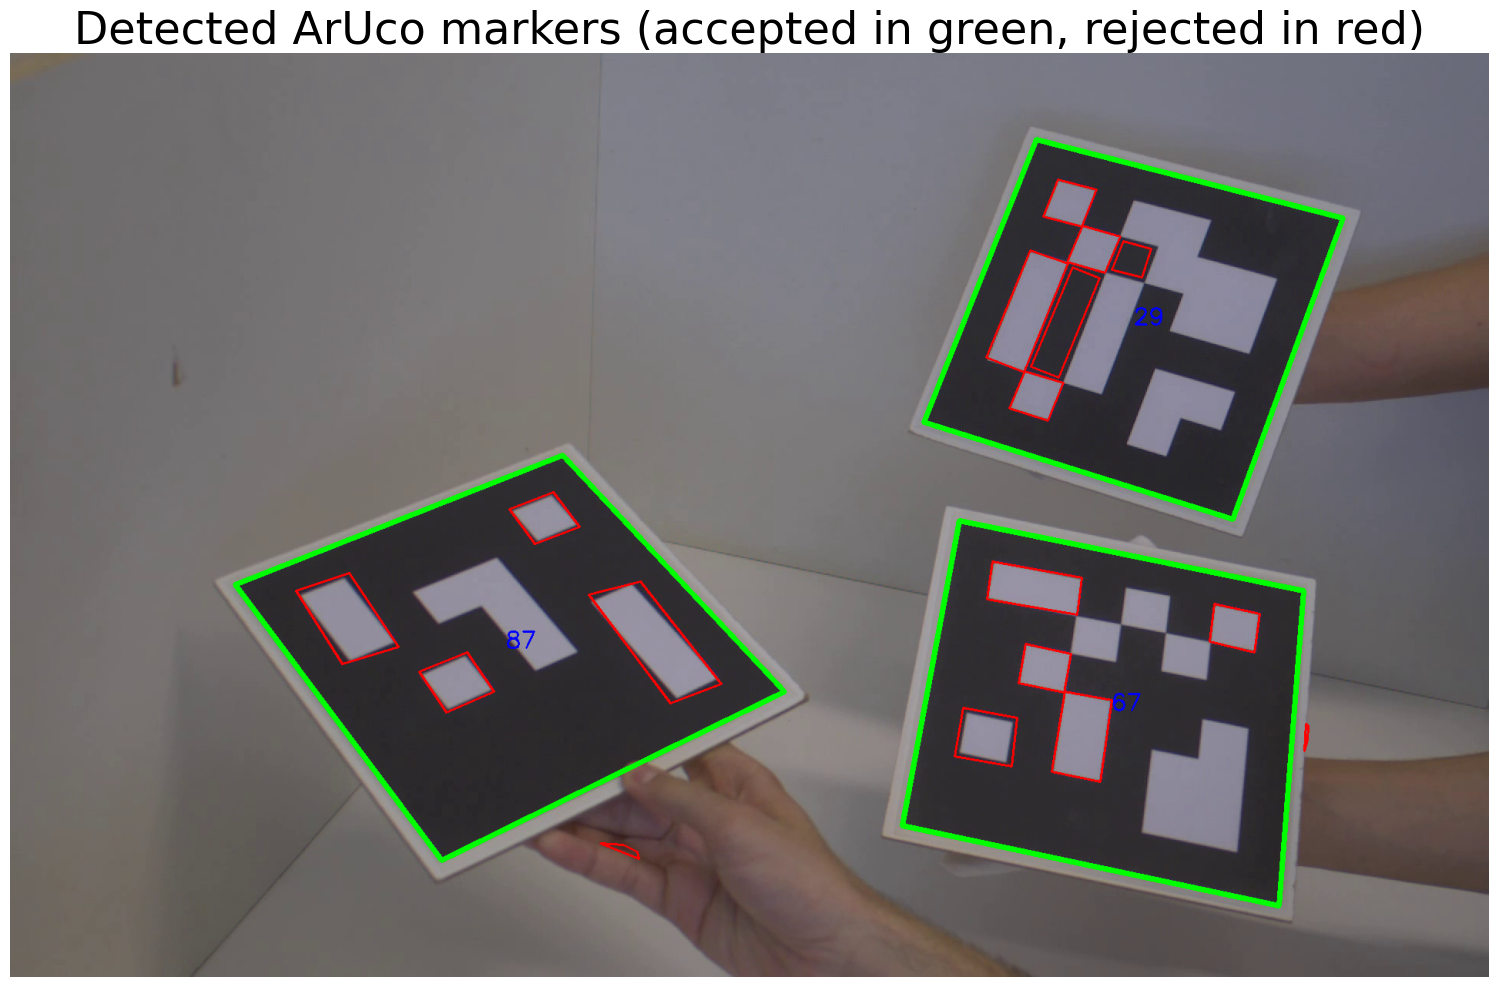

In [280]:
draw = draw_aruco(img.copy(), corners, ids, rejected) ###
plot_images(draw, titles=['Detected ArUco markers (accepted in green, rejected in red)'])

### Odhad pozice kamery vzhledem k ArUco
Když už známe 4 rohy všech značek na obrázku, můžeme využít funkci [`cv2.solvePnP`](https://docs.opencv.org/4.x/d5/d1f/calib3d_solvePnP.html) k odhadu polohy kamery. Známe **pozici markeru na obrázku**, **reálný tvar markeru** (čtverec o dané velikosti) a **parametry kamery** (kalibrace). Díky tomu umíme spočítat **rotační vektor a vektor posunutí** pro přechod ze souřadnicového systému reálného objektu do systému kamery.

![](data/image/pnp.jpg "PnP [https://docs.opencv.org/4.x/d5/d1f/calib3d_solvePnP.html]")

#### Vektor posunutí (translation vector)
Hodnoty ve vektoru posunutí budou v jednotce velikosti značky. 
Norma vektoru je vzdálenost značky od kamery.

#### Vektor otočení (rotation vector)
Možná si říkáte: *Jak můžeme reprezentovat rotaci jediným vektorem?* 
<br>\- Poměrně jednoduše! Směr vektoru značí osu, kolem které rotujeme, norma vektoru značí úhel otočení.

#### Rohy ArUco v reálném světě
Vytvořte funkci, která vygeneruje souřadnice rohů (X, Y, Z) ArUco markeru tak, aby byl střed v souřadnicích (0, 0, 0).

<div style="color: blue; text-align: right">[ 0,25 bodu ]</div>


In [281]:
def generate_marker_corners(marker_size: float) -> np.ndarray:
    """Generate real-world coordinates of an ArUco marker, with the origin in the middle of the marker.

    Parameters
    ----------
    marker_size : float
        actual size of marker (for example in mm)

    Returns
    -------
    np.ndarray
        NumPy array representing the 4 ArUco corners
    """
    
    corners = np.array([
        [-marker_size/2, marker_size/2, 0], #top left
        [marker_size/2, marker_size/2, 0], #top right
        [marker_size/2, -marker_size/2, 0], #bottom right
        [-marker_size/2, -marker_size/2, 0] #bottom left
    ])
    return corners

In [282]:
marker_size = 20
marker_points = generate_marker_corners(marker_size) ###
print(marker_points)

[[        -10          10           0]
 [         10          10           0]
 [         10         -10           0]
 [        -10         -10           0]]


#### Výpočet odhadu

Nalezněte rotační a translační vektory pro každý ArUco marker v obrazu. Rotační a translační vektory si uložte do listu, abyste je pak mohli použít k projekci 3D modelu na marker. Při řešení **PnP** využijte metodu `flags=cv2.SOLVEPNP_IPPE_SQUARE`.

<div style="color: blue; text-align: right">[ 0,5 bodu ]</div>

In [283]:
def get_marker_poses(marker_points, corners, camera_matrix, distortion_coeff):
    """Get rotation and translation vectors from 3D-2D point correspondences.

    Parameters
    ----------
    marker_points : np.array
        marker points in marker coordinate system

    corners: np.array
        image points of markers

    camera_matrix: np.array
        camera intrinsic matrix
        
    distorion_coeff: np.array
        distortion coefficients


    Returns
    -------
    rvecs: list
        list of rotation vectors for each marker
    tvecs: list
        list of translation vectors for each marker
    """
    rvecs = []
    tvecs = []

    ... ### iterate through all markers(corners) and find the vectors
    for corner in corners:
        _, rvec, tvec = cv2.solvePnP(marker_points, corner, camera_matrix, distortion_coeff, flags=cv2.SOLVEPNP_IPPE_SQUARE)
        rvecs.append(rvec)
        tvecs.append(tvec)
    return rvecs, tvecs

In [284]:
rvecs, tvecs = get_marker_poses(marker_points, corners, camera_matrix, dist_coefs)

print('rotation vector:\n', rvecs[0])                                     
print('translation vector (object to camera):\n', tvecs[0])       

rotation vector:
 [[     2.2756]
 [   -0.69988]
 [    0.48929]]
translation vector (object to camera):
 [[    -12.534]
 [     5.9184]
 [     101.97]]


### Projekce bodů z ArUco do obrazu
S funkcí [`cv2.projectPoints`](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga1019495a2c8d1743ed5cc23fa0daff8c) umíme převést bod ze souřadnicového systému reálného objektu (ArUco) do obrazu. OpenCV sice má [`cv2.drawFrameAxes`](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gab3ab7bb2bdfe7d5d9745bb92d13f9564), ale pro lepší pochopení je níže vlastní implementace.

Nastudujte funkci `draw_axes` a použijte ji k nakreslení souřadnicového systému ArUco značky (X, Y, Z osy) do kopie původního obrázku (img).

In [285]:
def draw_axes(image, camera_matrix, distortion_coeff, tvecs, rvecs, marker_size):
    """
    Draws axes on an image using the rotation and translation vectors.

    Note:    
    `img = cv2.drawFrameAxes(img, matrix, distortion_coeff, rvec, tvec, marker_size)` will yield the same result.
    The whole point of this function is to show how projectPoints can be used to draw ArUco axes.
    """
    for i in range(len(rvecs)):
        # np.eye represents identity matrix
        axes_points = np.eye(3) * marker_size
        # project axes onto image
        imagePoints, _ = cv2.projectPoints(axes_points, rvecs[i], tvecs[i], camera_matrix, distortion_coeff)
        imagePoints = imagePoints.astype(int)
        # projected x, y, z axes
        x = imagePoints[0][0]
        y = imagePoints[1][0]
        z = imagePoints[2][0]
        
        # middle of marker in real world coordinates
        zero = np.array([[0, 0, 0]])

        # middle of marker in image coordinates
        # average of the 4 detected corners would yield the same result
        marker_center, _ = cv2.projectPoints(zero.astype(float), rvecs[i], tvecs[i], camera_matrix, distortion_coeff)

        # squeeze to remove the extra dimension. As you've probably already noticed, OpenCV tends to return arrays with redundant dimensions.
        # in this case: [[[x, y]]] -> [x,  y]
        marker_center = marker_center.squeeze().astype(int)
        
        cv2.line(image, tuple(marker_center), tuple(x), Color.RED, 5)
        cv2.line(image, tuple(marker_center), tuple(y), Color.GREEN, 5)
        cv2.line(image, tuple(marker_center), tuple(z), Color.BLUE, 5)
    return image

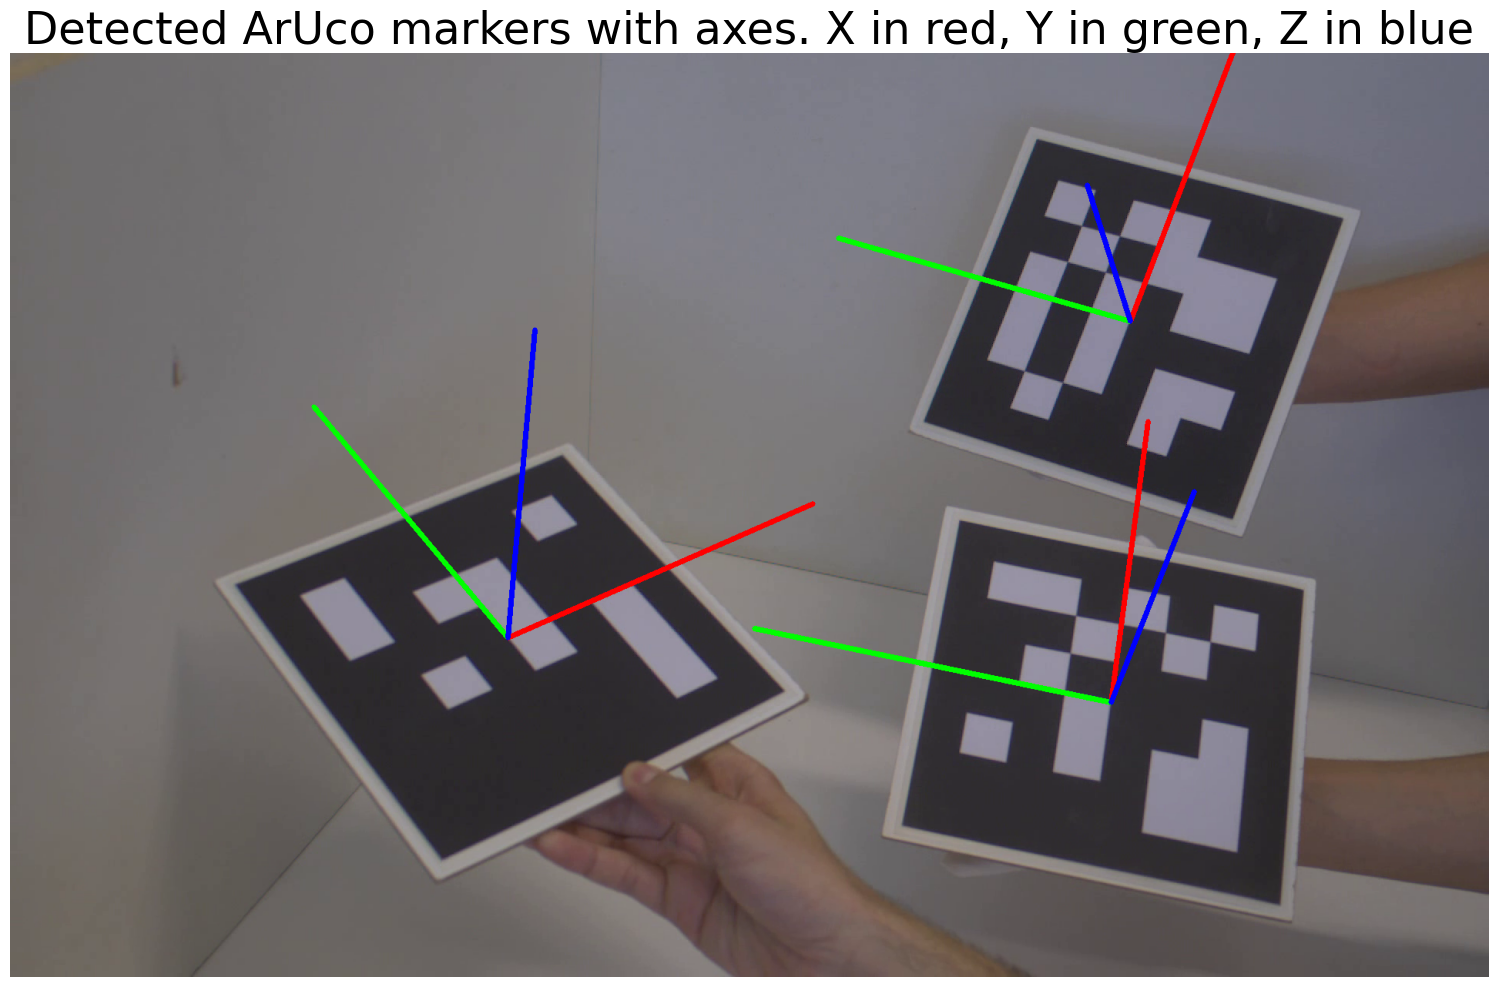

In [286]:
axis_drawn = img.copy()
axis_drawn = draw_axes(axis_drawn, camera_matrix, dist_coefs, tvecs, rvecs, marker_size) ###
plot_images(axis_drawn, titles=['Detected ArUco markers with axes. X in red, Y in green, Z in blue'])

## Načítání 3D objektů
K načítání 3D objektů použijeme knihovnu [`trimesh`](https://trimesh.org). Experimentovat s vlastními 3D modely samozřejmě můžete, ale doporučujeme úkol napřed vypracovat s daty, které jsou ve složce `data/3D`.

Doporučený postup načítání:
- iterace přes složku s 3D soubory
- načítání 3D objektu za pomoci [trimesh.load(..., force='mesh')](https://trimesh.org/trimesh.html#trimesh.load)
- přidání do listu

Parametr `force='mesh'` je potřebný pro přístup k `mesh.vertices` a `mesh.faces` (mesh je načtený 3D objekt).

<div style="color: blue; text-align: right">[ 0,1 bodu ]</div>

In [287]:
mesh_dir = os.path.join('data', '3D')
mesh_list = []

for file in os.listdir(mesh_dir): ###
    file_path = "data/3D/" + file ###
    print(file_path)
        
    mesh = trimesh.load(file_path, force='mesh') ###
    mesh_list += [mesh]

data/3D/utah_teapot.obj
data/3D/bunny.obj
data/3D/mars_ingenuity_helicopter.glb
data/3D/gombok.obj


### Pochopení reprezentace
Wire-mesh model je v trimesh reprezentován jako:
- `mesh.vertices`: vektory
- `mesh.faces`: trojúhelníky skládající se z 3 vektorů

<div style="color: blue; text-align: right">[ 0,2 bodu ]</div>

#### `trimesh.vertices`
`Vertices` je tedy numpy array, kde každý řádek reprezentuje 1 vektor. 

Vypiště první vektor zvoleného meshe.

In [288]:
mesh = mesh_list[1].copy() ### choose id that corresponds to the standford bunny
print(mesh.vertices[0]) ###

[ -0.0034102     0.13032    0.021754]


#### `trimesh.faces`
`Faces` je také numpy array, kde každý řádek reprezentuje vektor. Složky tohoto vektoru jsou indexy do `vertices`. Minimální složka tedy bude `0` a maximální složka bude `vertices.shape[0]`.

Příklad prvku faces:
`[0, 1, 2]` reprezentuje trojúhelník, kde každý roh reprezentuje 1 vektor, konkrétně `vertices[0], vertices[1], vertices[2]`.

Vypište první 'facu' zvoleného meshe.

In [289]:
mesh.faces[0] ###

TrackedArray([1068, 1646, 1577])

#### Seznam trojúhelníků

Pokud chceme model reprezentovat jako seznam trojúhelníků, tedy seznam trojic vektorů, stačí za pomoci `faces` zaindexovat `vertices`.

Vypiště první trojúhelník zvoleného meshe.

In [290]:
###
for index in mesh.faces[0]:
   print(mesh.vertices[index]) 

[  -0.086562     0.14249   0.0084327]
[  -0.089698     0.13971    0.013775]
[  -0.089491     0.14393    0.012488]


### Předzpracování modelů
Předpokládáme, že spodní část načteného objektu je vodorovná s rovinou XY. Nemáme ale zaručeno, že se model vejde na ArUco kód a jeho spodní část lícuje s rovinou XY. Je zároveň i zapotřebí model orotovat tak, aby spodní část objektu byla opravdu vodorovná s rovinou XY.

Model je třeba:
- **vycentrovat**, využijte vlastností meshe.
- **znormovat** na jedničku, vyžijte [ `apply_scale `](https://trimesh.org/trimesh.path.html#trimesh.path.Path2D.apply_scale) a funkcí `max`, `min`.
- **položit na XY**.

Vytvořte funkci `preprocess_mesh`, která tyto operace provede. Použijte `plot_mesh` k vizualizaci předzpracování. Mějte na paměti, že funkce `plot_mesh` vykresluje objekt v rovině XY.

<div style="color: blue; text-align: right">[ 0,5 bodu ]</div>

![](data/image/kralici-pipeline.png)


In [291]:
def preprocess_mesh(mesh_unprocessed: trimesh.base.Trimesh) -> trimesh.base.Trimesh:
    """Transformer which preprocesses a 3D mesh in-place.

    Parameters
    ----------
    mesh : trimesh.base.Trimesh
        3D model

    Returns
    -------
    trimesh.base.Trimesh
        same model but preprocessed
    """
    mesh = mesh_unprocessed.copy()
    
    #Center model (subtract centroid)
    centroid = np.array([np.mean(mesh.vertices[:,0]), np.mean(mesh.vertices[:,1]), np.mean(mesh.vertices[:,2])])
    mesh.apply_translation(-centroid) ###
    
    # Scale centered model so that its projection onto XY plane fits into a square of size 1
    x_min = np.min(mesh.vertices[:,0])
    y_min = np.min(mesh.vertices[:,1])
    x_max = np.max(mesh.vertices[:,0])
    y_max = np.max(mesh.vertices[:,1])
    max_size = max(x_max - x_min, y_max - y_min)
    factor = 1 / max_size
    mesh.apply_scale(factor)
    
    # Translate just so the model sits directly on XY plane
    z_min = mesh.vertices[:, 2].min()
    mesh.apply_translation([0, 0, -z_min]) ###

    return mesh

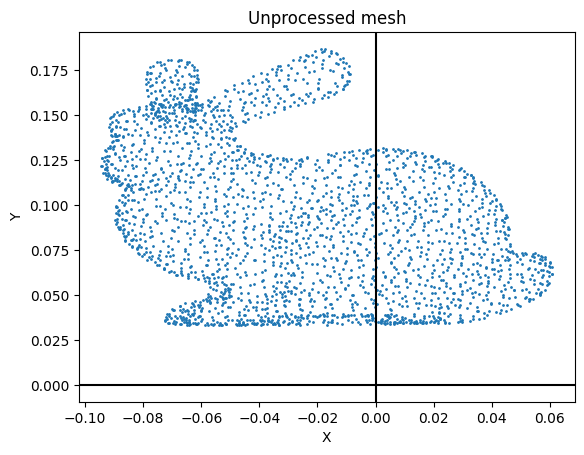

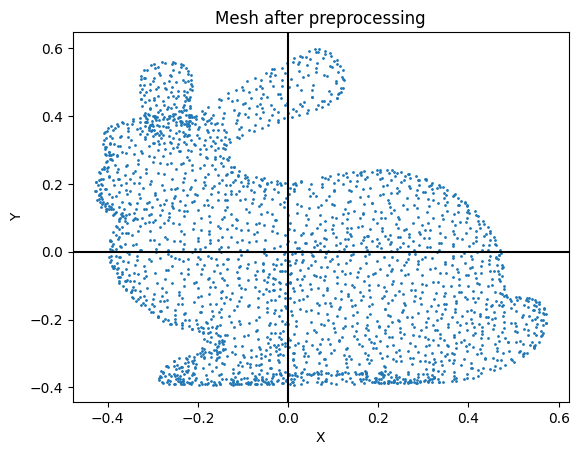

In [292]:
plot_mesh(mesh, title='Unprocessed mesh') ###
mesh_processed = preprocess_mesh(mesh)
plot_mesh(mesh_processed, title='Mesh after preprocessing') ###

Model následně otočte o **90 stupňů** kolem **osy X**, aby "seděl" na ArUco markeru a model zobrazte. Výsledkem bude model "sedící" na rovině XY (pohled shora). Využijte modulu [`trimesh.transformation`](https://trimesh.org/trimesh.transformations.html) pro vytvoření rotační matice.

<div style="color: blue; text-align: right">[ 0,25 bodu ]</div>

In [293]:
def rotate_mesh(mesh_unrotated: trimesh.base.Trimesh) -> trimesh.base.Trimesh:
    """Transformer which rotates model around its X axis by 90 degrees.

    Parameters
    ----------
    mesh : trimesh.base.Trimesh
        3D model

    Returns
    -------
    trimesh.base.Trimesh
        rotated 3D model
    """
    mesh = mesh_unrotated.copy()

    # Rotate around x axis by 90 degrees
    rotation_matrix = trimesh.transformations.rotation_matrix(np.pi / 2, (1, 0, 0))
    
    mesh.apply_transform(rotation_matrix)
    return mesh

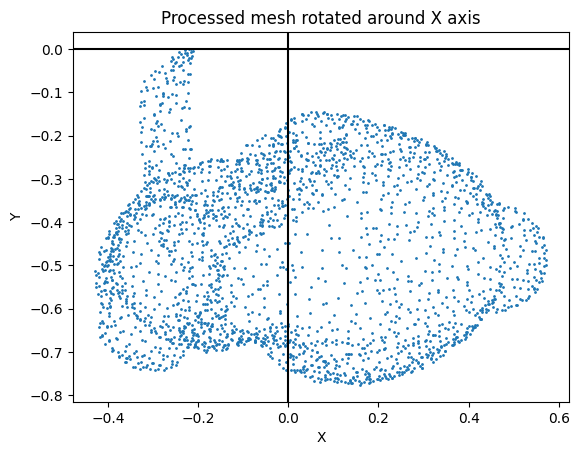

In [294]:
mesh_rotated = rotate_mesh(mesh_processed)
plot_mesh(mesh_rotated, title='Processed mesh rotated around X axis') ###

Předzpracování a otočení aplikujte na všechny 3D modely. Využijte funkce `map`.

In [295]:
mesh_list = list(map(preprocess_mesh, mesh_list)) ### preprocess_mesh
mesh_list = list(map(rotate_mesh, mesh_list)) ### rotate_mesh

## Projekce na ArUco (obrázek)
Konečně se blížíme k té zábavné části, kde si zobrazíte vámi zvolené 3D modely na ArUco. Naplňte slovník `id_to_mesh`. Klíčem je ID ArUco značky, hodnotou 3D model, který chcete na ArUco zobrazit.

In [296]:
id_to_mesh = {}
min_len = min(len(mesh_list), len(ids))

for i, marker_id in enumerate(ids.ravel()[:min_len]):
    id_to_mesh[marker_id] = mesh_list[i] ###

Vytvořte funkci, která bere jako první parametr RGB obrázek a vrací RGB obrázek. Funkce na přijatý frame projektuje 3D model na každý detekovaný ArUco kód. Využijte znalosti a funkce, které byly vytvářeny v předchozích bodech úkolu.

**Požadavky na funkci**:
- Detekujte ArUco kód z přijatého obrázku. Na každý detekovaný ArUco kód zobrazte model podle `id_to_mesh`.
- Funkce by měla zvládat případy, kde nejsou detekované všechny markery. Později ji použijete na zpracování videa (stane se, že nebude viditelný celý ArUco kód, tudíž nebude detekován)
- Nalezněte rotační a translační vektory. Projektuje vrcholy modelu do prostoru obrazu. Nezapomeňte vrcholy meshe přeškálovat dle `marker_size` použité při zavolání funkce `generate_marker_corners`.
- Model stačí zobrazit jako wire-mesh, tzn. vykreslete všechny trojúhelníky modelu např. pomocí `cv2.drawContours`
- Jednotlivé modely můžete, ale nemusíte odlišit jinou barvou

<div style="color: blue; text-align: right">[ 1 bod ]</div>

In [297]:
def project_aruco(frame: np.ndarray, marker_size, camera_matrix, distortion_coeff, detector: cv2.aruco.ArucoDetector, id_to_mesh: Dict[int, trimesh.base.Trimesh]):    
    frame_gray = to_gray(frame)
    corners, ids, _ = detector.detectMarkers(frame_gray)
    if ids is None:
        return frame
    
    marker_points = generate_marker_corners(marker_size)
    rvecs, tvecs = get_marker_poses(marker_points, corners, camera_matrix, distortion_coeff)

    #pallete = np.array([50, 100, 150])
    #colors = {marker_id: np.roll(pallete, i) for i, marker_id in enumerate(ids.flatten())}
    
    for i, marker_id in enumerate(ids.flatten()):
        if marker_id not in id_to_mesh: continue 
        mesh = id_to_mesh[marker_id].copy()
        mesh = preprocess_mesh(mesh)
        
        mesh.apply_scale(marker_size)

        projected, _ = cv2.projectPoints(mesh.vertices, rvecs[i], tvecs[i], camera_matrix, distortion_coeff)
        projected = projected.squeeze().astype(int)
        
        #curr_color = colors[marker_id]
        
        for face in mesh.faces:
            contours = [projected[idx] for idx in face]
            contours = np.array(contours, dtype=np.int32).reshape((-1, 1, 2))
            cv2.drawContours(frame, [contours], -1, color=(150, 50, 100), thickness=1)
            #cv2.drawContours(frame, [contours], -1, color=tuple(curr_color.tolist()), thickness=1)
    return frame

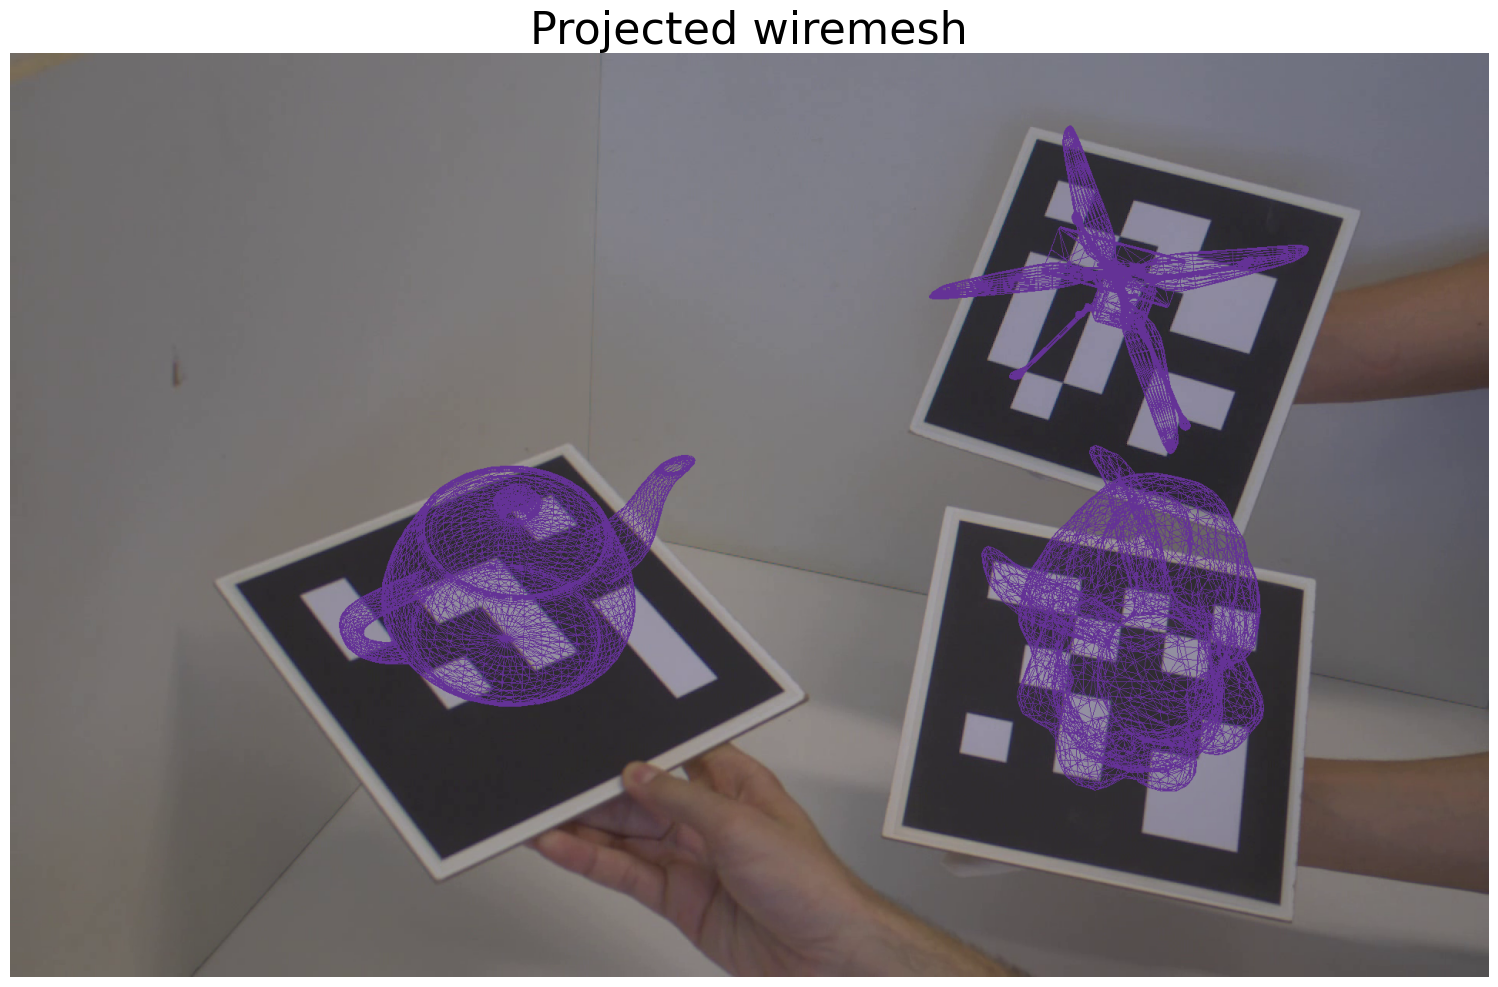

In [298]:
kwargs = {
    'marker_size': marker_size, 'camera_matrix': camera_matrix, 'distortion_coeff': dist_coefs,
    'detector': inference.detector, 'id_to_mesh': id_to_mesh
}

trimesh_img = project_aruco(img.copy(), **kwargs)
plot_images(trimesh_img, titles=['Projected wiremesh'])

## Zpracování videa
Aplikujte vámi vytvořenou funkci na video a uložte do souboru `out.mp4`. Použijte k tomu funkci `process_video(input_video_path, output_video_path, update_fn=your_fn, **fn_kwargs)`.

Doporučení:
- Jako první krok si zkuste na video aplikovat `video_test`, abyste se ujistili, že zpracování videa funguje na vašem systému.
- Pokud by se vám objevovala chyba *"moov atom not found"*, stáhněte si video přimo z gitlabu a nahrajte do složky.
- Následně můžete využít `draw_axes` k ověření, že správně detekujete ArUco.
- Až pak se pouštějte do projekce 3D modelů. Vyhnete se tak zbytečným chybám.
- Dávejte si pozor na `image.shape`, vracený obrázek musí mít stejné rozměry.

<div style="color: blue; text-align: right">[ 0,2 bodu ]</div>


In [299]:
def video_test(frame):
    return frame

input_video_path = os.path.join('data', 'video', 'aruco-choreo.mp4')
process_video(input_video_path, 'test.mp4', video_test)

Processing video with function video_test: 100%|████████████████████████████████████████████████████████████████████████████| 411/411 [00:03<00:00, 124.50frame/s]
Video processing complete. Output saved at: test.mp4.


In [300]:
def draw_axes_video(bgr, detector, camera_matrix, distortion_coeff, tvecs, rvecs, marker_size):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    corners, _, _ = detector.detectMarkers(gray)
    rvecs, tvecs = get_marker_poses(marker_points, corners, camera_matrix, distortion_coeff)
    return draw_axes(bgr, camera_matrix, distortion_coeff, tvecs, rvecs, marker_size)

process_video(input_video_path, 'axes.mp4', draw_axes_video, inference.detector, camera_matrix, dist_coefs, tvecs, rvecs, marker_size)

Processing video with function draw_axes_video: 100%|████████████████████████████████████████████████████████████████████████| 411/411 [00:07<00:00, 58.09frame/s]
Video processing complete. Output saved at: axes.mp4.


In [301]:
output_video_path = 'out.mp4'
process_video(input_video_path, output_video_path, update_fn=project_aruco, **kwargs)

Processing video with function project_aruco: 100%|██████████████████████████████████████████████████████████████████████████| 411/411 [00:38<00:00, 10.77frame/s]
Video processing complete. Output saved at: out.mp4.



# Bonus
Pro získání většího množství bodů vám nabízíme jeden ze dvou níže specifikovaných úkolů.
Úkoly nejsou nutně náročnější než hlavní část domácího úkolu, ale prohloubí vaše znalosti, nebo si minimálně něco procvičíte.<br>
Můžete zapracovat na:
1. **Vizualizaci pohybu ArUco kódů <span style="color:blue">(1 bod)</span>**.
    - Ve videu zobrazte předešlé pozice ArUco kódů, tedy vizualizujte stopu/trail kódů.
    - Budete potřebovat nějakou strukturu, do které si budete ukládat předešlé pozice. Dobrý start je ukládat 24+ předešlých pozicí, jelikož framerate videa je 24 FPS.
    - Strukturu si pak můžete předat do funkce process_video a měnit jí za běhu.
2. **Zobrazení obrázků na ArUco kódy <span style="color:blue">(1 bod)</span>**.
    - Připravte si 3 obrázky vaší volby a zobrazte je na ArUco značky.
    - Musíte ale zachovat poměr stran obrázků (fill/fit to scale).